# Excess Deaths in the United States

This notebook analyzes excess deaths in the US, using data form [NCHS Mortality Surveillance](https://gis.cdc.gov/grasp/fluview/mortality.html).  This data dump is particularly for flu, but it includes total deaths, which is the number we're looking for.

The goal is to reproduce the [Financial Times analysis](https://www.ft.com/content/6bd88b7d-3386-4543-b2e9-0d5c6fac846c) and look at states the FT doesn't directly cover.

## Intro to Excess Deaths

Estimating COVID death rates is a complex problem.  This analysis looks at _excess deaths_, which are the deaths above what we would expect for a particular week in an ordinary year.  The way to compute this is to take the average deaths in a given week for the last $N$ years (I use 4, because that's what my data allows), and compare the 2020 deaths in that week to the average.  This accounts for two things:

- Seasonal variation, by matching each week with its corresponding week in the other years
- Yearly variation, by averaging over several years

We are working with raw death counts, not per-capita death rates, so we would expect some increase over time as population increases.  As we will see, the 2020 death patterns are so pronounced that this isn't an issue for the conclusions we can draw from this analysis.

Also, as noted in FT, death counts are revised up as the data for a particular week becomes more complete. The most recent weeks, therefore, undercount deaths (sometimes quite severely).

Throughout the notebook, I will use a few terms:

* The **background years** are the historical data used for comparison with 2020. From available data, this is 2016–2019.
* The **current year** is 2020.

## Setup

Load some useful Python modules:

In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


Bad key "text.kerning_factor" on line 4 in
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load the Data

We'll start by loading in data from our CSV files:

In [3]:
raw_data = pd.concat([pd.read_csv(p) for p in Path('.').glob('*_Data.csv')], ignore_index=True)
raw_data.head()

,AREA,SUB AREA,AGE GROUP,SEASON,WEEK,THRESHOLD,BASELINE,PERCENT P&I,NUM INFLUENZA DEATHS,NUM PNEUMONIA DEATHS,TOTAL DEATHS,PERCENT COMPLETE
0,National,NaN,All,2015-16,40,6.5,6.1,6.3,14,"3,197","50,950",> 100%
1,National,NaN,All,2015-16,41,6.6,6.2,6.3,7,"3,131","49,830",> 100%
2,National,NaN,All,2015-16,42,6.7,6.3,6.4,16,"3,214","50,667",> 100%
3,National,NaN,All,2015-16,43,6.8,6.4,6.3,17,"3,163","50,384",> 100%
4,National,NaN,All,2015-16,44,6.9,6.5,6.6,20,"3,353","51,158",> 100%


Trim down to columns we care about, except for year, which we will add back in next:

In [4]:
deaths = pd.DataFrame({
    'Level': raw_data['AREA'].astype('category'),
    'Region': raw_data['SUB AREA'].fillna('USA').astype('category'),
    'Deaths': raw_data['TOTAL DEATHS'].astype('str'),
    'PctComplete': raw_data['PERCENT COMPLETE'].str.replace(r'(?:>\s*)?(\d+(?:\.\d*)?)\s*%', r'\1').astype('f4')
})
deaths

,Level,Region,Deaths,PctComplete
0,National,USA,"50,950",100.000000
1,National,USA,"49,830",100.000000
2,National,USA,"50,667",100.000000
3,National,USA,"50,384",100.000000
4,National,USA,"51,158",100.000000
...,...,...,...,...
1955,State,Washington,"1,131",100.000000
1956,State,Washington,"1,093",100.000000
1957,State,Washington,"1,012",98.099998
1958,State,Washington,945,91.599998


The flu season starts on week 40. So for the 2015-16 season, weeks 40-52 are 2015, and weeks 1-39 are 2016.  Let's make a Year 
column to deal with this better.

In [5]:
deaths['Year'] = raw_data['SEASON'].str.replace(r'-\d+$', '')
deaths['Week'] = raw_data['WEEK']
second_yr = deaths['Week'] < 40
deaths.loc[second_yr, 'Year'] = raw_data.loc[second_yr, 'SEASON'].str.replace(r'\d\d-', '')
deaths['Year'] = deaths['Year'].astype('i4')
deaths

,Level,Region,Deaths,PctComplete,Year,Week
0,National,USA,"50,950",100.000000,2015,40
1,National,USA,"49,830",100.000000,2015,41
2,National,USA,"50,667",100.000000,2015,42
3,National,USA,"50,384",100.000000,2015,43
4,National,USA,"51,158",100.000000,2015,44
...,...,...,...,...,...,...
1955,State,Washington,"1,131",100.000000,2020,20
1956,State,Washington,"1,093",100.000000,2020,21
1957,State,Washington,"1,012",98.099998,2020,22
1958,State,Washington,945,91.599998,2020,23


And now convert deaths to numbers (we waited until now because the previoius step can remove some strings).

In [6]:
deaths['Deaths'] = deaths['Deaths'].str.replace(',', '').astype('f4')
deaths.head()

,Level,Region,Deaths,PctComplete,Year,Week
0,National,USA,50950.0,100.0,2015,40
1,National,USA,49830.0,100.0,2015,41
2,National,USA,50667.0,100.0,2015,42
3,National,USA,50384.0,100.0,2015,43
4,National,USA,51158.0,100.0,2015,44


Index some useful deaths:

In [7]:
weekly = deaths.set_index(['Region', 'Year', 'Week'])['Deaths']
weekly.sort_index(inplace=True)
weekly.describe()

count     1960.000000
mean      8196.083984
std      17511.941406
min        154.000000
25%        687.750000
50%       1751.000000
75%       3442.500000
max      76892.000000
Name: Deaths, dtype: float64

Compute the *expected* deaths - years 2016-2019:

In [8]:
bg_years = [2016, 2017, 2018, 2019]

In [9]:
background = deaths[(deaths['Year'] >= 2016) & (deaths['Year'] < 2020)]
expected = background.groupby(['Region', 'Week'])['Deaths'].mean()
expected.head()

Region  Week
Idaho   1       291.75
        2       292.00
        3       273.00
        4       276.25
        5       286.25
Name: Deaths, dtype: float32

And we'll get the 2020 deaths:

In [10]:
current = deaths[deaths['Year'] == 2020].set_index(['Region', 'Week'])['Deaths']
current.head()

Region  Week
USA     1       59834.0
        2       60312.0
        3       58878.0
        4       58384.0
        5       57815.0
Name: Deaths, dtype: float32

Now, not all data is complete. Let's only keep current data that is reported as being at least 95% complete:

In [11]:
complete = deaths[deaths['Year'] == 2020].set_index(['Region', 'Week'])['PctComplete'] >= 95

## US Excess Deaths

We'll start by looking at excess deaths in the U.S., before we get to the state level.  I'm going to build the chart up piece by piece, so we can see how the different pieces come together.

Let's start by plotting the current (2020) US deaths:

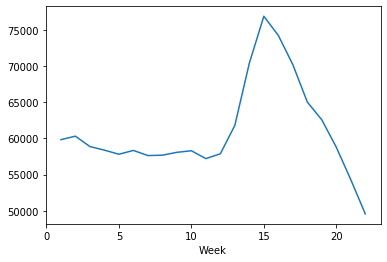

In [12]:
current[complete].loc['USA'].plot()

Note that, even with the most recent week removed, there is still an unrealistic drop.  This is consistent with FT's reporting; not as severe as if we included week 17, but still a drop.  It's crucial to realize this drop is **not** a drop in deaths; it just means not all deaths from that week have been reported.

Now let's plot the average weekly deaths for our background years (2016-2019):

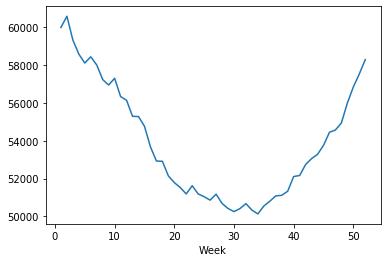

In [13]:
expected.loc['USA'].plot()

When we put these together, we get a plot that lets us compare 2020 deaths to average deaths:

In [14]:
def ovl_deaths(region):
    bg = expected.loc[region]
    cur = current[complete].loc[region]
    plt.plot(bg.index, bg, label='Average')
    plt.plot(cur.index, cur, label='2020')
    plt.legend()

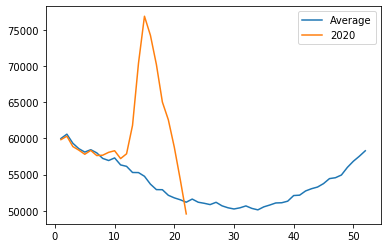

In [15]:
ovl_deaths('USA')

As one last touch, let's fill each individual year, as a fainter color, with average and 2020 on top.  This will let us see the individual years and their variation as context to better interpret the difference between 2020 and average.

In [16]:
def ovl_deaths(region):
    fig, ax = plt.subplots()
    bg = expected.loc[region]
    cur = current[complete].loc[region]
    avg = weekly.loc[region].mean()
    
    ax.axhline(avg, color='lightsteelblue', ls='-.', lw=0.5)
    
    for year in bg_years:
        old = weekly.loc[(region, year)]
        ax.plot(old.index, old, color='lightblue', alpha=0.8)
        
    ax.plot(bg.index, bg, label='Average')
    ax.plot(cur.index, cur, label='2020')
    
    bg_c, cur_c = bg.align(cur)
    base = np.minimum(bg_c, cur_c)
    ax.fill_between(bg_c.index, base, cur_c, alpha=0.2, color='red')
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Deaths')
    ax.set_title(f'{region} Excess Deaths')
    ax.legend()
    
    weeks = bg.index.values
    wk_origin = pd.to_datetime('2019-12-31')
    wk_dates = pd.Series(pd.to_timedelta(weeks, 'W') + wk_origin)
    months = wk_dates.dt.month
    first = ~months.duplicated()
    ticks = weeks[first]
    labels = wk_dates[first].dt.month_name()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xticks(weeks, minor=True)
    
    def fwd(x):
        return (x - avg) / avg
    
    def rev(x2):
        return x2*avg + avg
    
    sy = ax.secondary_yaxis('right', functions=(fwd,rev))
    sy.set_ylabel('Frac. above Average')
    return sy

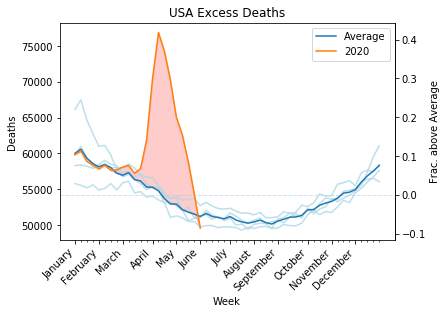

In [17]:
ovl_deaths('USA')

In [18]:
np.datetime64('2019-12-31') + np.timedelta64(5, 'W')

numpy.datetime64('2020-02-04')

The blue line is average deaths for the week, and the orange line is 2020 deaths. The grey lines are the individual years in our background data, so we can observe year-to-year variation in weekly death tolls.  One could make an argument that we should start our _y_ axis at 0, because visually this makes the peak look larger than it is. It looks like we double the number of deaths, but actually only increase it by about 20%.  However, this view makes it easier to compare the peak to the year-to-year variation.  The right-hand version of the _y_ axis shows the relative increase in deaths as a fraction of the overall average weekly deaths for the background years (without seasonal adjustments).

To interpret this chart, there are a few things to observe:

1. There is a spike in deaths, when usual death tolls go _down_. This suggests a real and abnormal effect - something is different about 2020.
2. Compare the spike (distance between orange peak and mean) with the usual variation between years (width of the pack of grey lines).  When we hit the COVID peak, we are clearly outside the realm of normal deaths; the difference between peak and average is 3-5 times the normal variation between years. There are, of course, ways to formalize this measurement but we can compare the trend well enough here.

We also notice one of our years has a high Week 1 - which is it?

In [19]:
weekly.swaplevel().loc[('USA', 2)].sort_values()

C:\Users\michaelekstrand\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Year
2016    55525.0
2019    58361.0
2020    60312.0
2017    60980.0
2018    67495.0
Name: Deaths, dtype: float32

2018 (the 2017-2018 flu season) has particularly high background deaths.  If we look that season up in the Flu Tracker, we'll also see that it was a particularly bad flu season.

## Extra Deaths by State

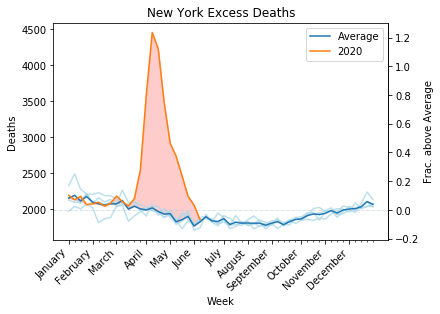

In [20]:
ovl_deaths('New York')

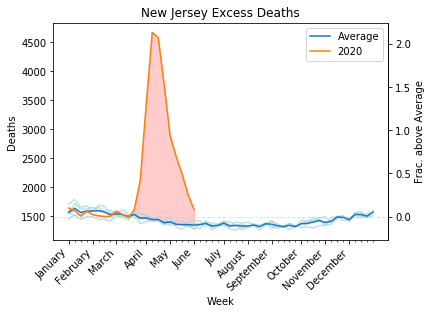

In [21]:
ovl_deaths('New Jersey')

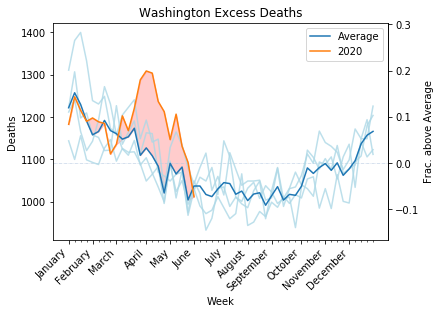

In [22]:
ovl_deaths('Washington')

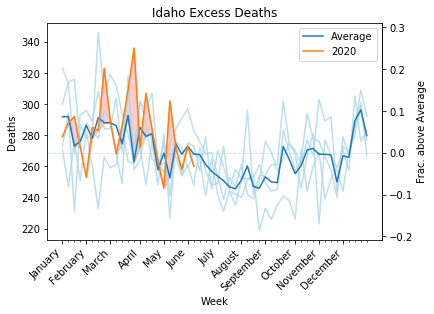

In [23]:
ovl_deaths('Idaho')

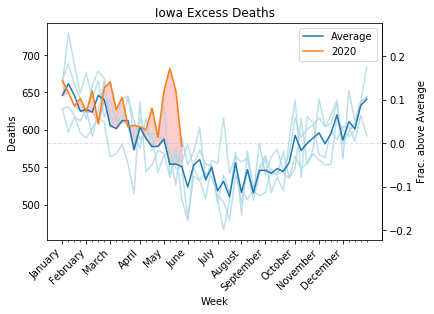

In [24]:
ovl_deaths('Iowa')

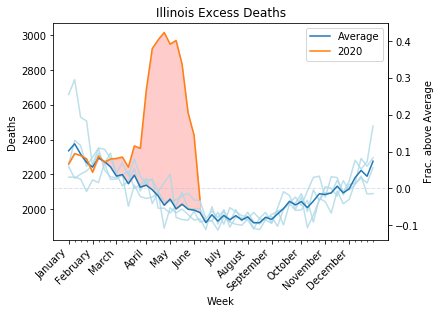

In [25]:
ovl_deaths('Illinois')

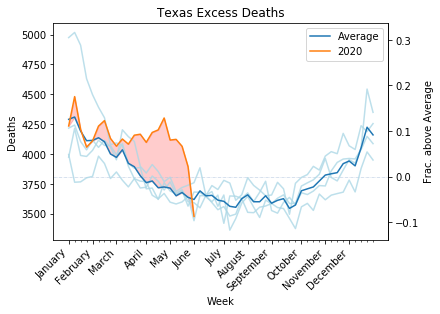

In [26]:
ovl_deaths('Texas')

## Provisional COVID Counts

How do these align with [provisional COVID counts](https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab) from the CDC?

In [27]:
covid = pd.read_csv('CDCProvisionalCOVID.csv')
covid.head()

,Data as of,Start week,End Week,Group,State,Indicator,COVID-19 Deaths,Total Deaths,Percent of Expected Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,06/19/2020,02/01/2020,02/01/2020,By week,United States,Week-ending,1.0,57965.0,0.98,3753.0,0.0,476.0,4230.0,NaN
1,06/19/2020,02/08/2020,02/08/2020,By week,United States,Week-ending,1.0,58480.0,0.98,3736.0,0.0,514.0,4251.0,NaN
2,06/19/2020,02/15/2020,02/15/2020,By week,United States,Week-ending,0.0,57757.0,0.98,3758.0,0.0,546.0,4304.0,NaN
3,06/19/2020,02/22/2020,02/22/2020,By week,United States,Week-ending,4.0,57833.0,1.00,3636.0,1.0,557.0,4196.0,NaN
4,06/19/2020,02/29/2020,02/29/2020,By week,United States,Week-ending,5.0,58218.0,1.01,3760.0,3.0,637.0,4399.0,NaN


These tables are not easy to work with - difficult names and dates that are in US date format. So we need to do some cleanup.

Also, this table gives a % of Expected Deaths, which is the same as our concept of excess deaths!  They are only using 2017-2019, instead of 2016-2019, but it's the same idea.

In [28]:
covid_deaths = pd.DataFrame({
    'Region': covid['State'],
    'WeekDate': pd.to_datetime(covid['Start week']),
    'CovidDeaths': covid['COVID-19 Deaths'],
    'TotalDeaths': covid['Total Deaths'],
    'PctExpected': covid['Percent of Expected Deaths']
})
covid_deaths.head()

,Region,WeekDate,CovidDeaths,TotalDeaths,PctExpected
0,United States,2020-02-01,1.0,57965.0,0.98
1,United States,2020-02-08,1.0,58480.0,0.98
2,United States,2020-02-15,0.0,57757.0,0.98
3,United States,2020-02-22,4.0,57833.0,1.00
4,United States,2020-02-29,5.0,58218.0,1.01


First, the COVID counts are reported by week *date*, not *number*, so we need to align them if we want to compare with the flu tracker data. Fortunately, Pandas gives us a 'weekofyear' accessor to do this conversion!

In [29]:
weeks = pd.Series(np.unique(covid_deaths.WeekDate))

In [30]:
covid_deaths['Week'] = covid_deaths['WeekDate'].dt.weekofyear
covid_deaths.head()

,Region,WeekDate,CovidDeaths,TotalDeaths,PctExpected,Week
0,United States,2020-02-01,1.0,57965.0,0.98,5
1,United States,2020-02-08,1.0,58480.0,0.98,6
2,United States,2020-02-15,0.0,57757.0,0.98,7
3,United States,2020-02-22,4.0,57833.0,1.00,8
4,United States,2020-02-29,5.0,58218.0,1.01,9


Let's now fill in the expected deaths line:

In [31]:
covid_deaths['ExpectedDeaths'] = covid_deaths['TotalDeaths'] / covid_deaths['PctExpected']
covid_deaths.head()

,Region,WeekDate,CovidDeaths,TotalDeaths,PctExpected,Week,ExpectedDeaths
0,United States,2020-02-01,1.0,57965.0,0.98,5,59147.959184
1,United States,2020-02-08,1.0,58480.0,0.98,6,59673.469388
2,United States,2020-02-15,0.0,57757.0,0.98,7,58935.714286
3,United States,2020-02-22,4.0,57833.0,1.00,8,57833.000000
4,United States,2020-02-29,5.0,58218.0,1.01,9,57641.584158


Another number we want - the deaths not attributed to COVID.  This is the total deaths minus the COVID deaths.  Some COVID death counts are not available - we are going to treat those as 0 for the purpose of drawing our chart.

In [32]:
covid_deaths['OtherDeaths'] = covid_deaths['TotalDeaths'] - covid_deaths['CovidDeaths'].fillna(0)
covid_deaths.head()

,Region,WeekDate,CovidDeaths,TotalDeaths,PctExpected,Week,ExpectedDeaths,OtherDeaths
0,United States,2020-02-01,1.0,57965.0,0.98,5,59147.959184,57964.0
1,United States,2020-02-08,1.0,58480.0,0.98,6,59673.469388,58479.0
2,United States,2020-02-15,0.0,57757.0,0.98,7,58935.714286,57757.0
3,United States,2020-02-22,4.0,57833.0,1.00,8,57833.000000,57829.0
4,United States,2020-02-29,5.0,58218.0,1.01,9,57641.584158,58213.0


Now let's filter by completeness, using the crude estimate that data isn't complete if we have less than 85% the expected deaths.

In [33]:
covid_deaths['IsComplete'] = covid_deaths['PctExpected'] >= 0.85

### Results

Now we can make charts like [The Economist](https://www.economist.com/graphic-detail/2020/04/16/tracking-covid-19-excess-deaths-across-countries)!

In [34]:
def cdc_death_plot(region):
    deaths = covid_deaths[covid_deaths.Region == region]
    deaths = deaths[deaths.IsComplete]
    
    fig, ax = plt.subplots()
    
    ax.plot(deaths.WeekDate, deaths.ExpectedDeaths, label='Expected')
    # ax.plot(deaths.WeekDate, deaths.TotalDeaths, label='2020')
    
    ex_base = np.minimum(deaths.ExpectedDeaths, deaths.OtherDeaths)
    ax.fill_between(deaths.WeekDate, deaths.OtherDeaths, deaths.TotalDeaths,
                    alpha=0.2, color='red', label='Attributed to COVID')
    ax.fill_between(deaths.WeekDate, 0, deaths.OtherDeaths,
                    alpha=0.2, color='purple', label='Not Attributed')
    
    # Set up the X axis labels
    months = deaths.WeekDate.dt.month
    firsts = ~months.duplicated()
    ticks = deaths.WeekDate[firsts]
    labels = ticks.dt.month_name()
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_xticks(deaths.WeekDate, minor=True)
    
    ax.set_ylabel('Deaths')
    ax.legend()

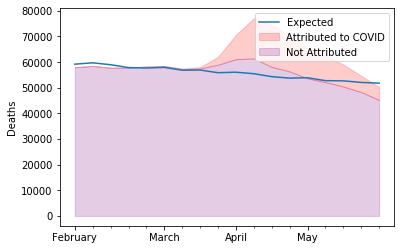

In [35]:
cdc_death_plot('United States')

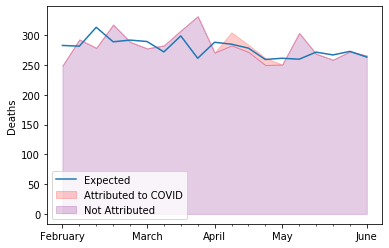

In [36]:
cdc_death_plot('Idaho')

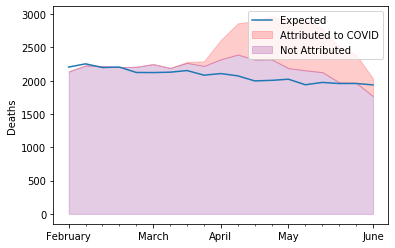

In [37]:
cdc_death_plot('Illinois')

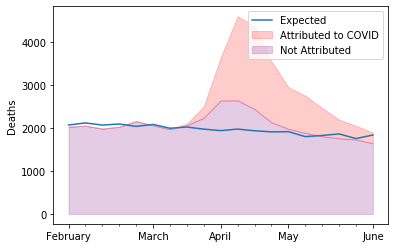

In [38]:
cdc_death_plot('New York')

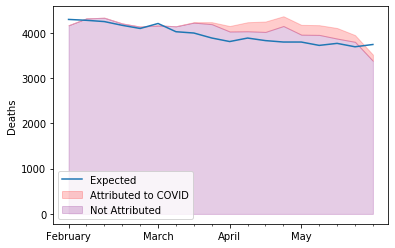

In [39]:
cdc_death_plot('Texas')